References: "[How to wrap a JAX function for use in PyMC](https://www.pymc.io/projects/examples/en/latest/case_studies/wrapping_jax_function.html)" and [this page](https://notebooks.githubusercontent.com/view/ipynb?color_mode=auto&commit=f6883db111b56c6d7216466b7b455a9b8229520c&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f676973742f74776965636b692f62616466323362373866643132333764313666346331393039646462653365332f7261772f663638383364623131316235366336643732313634363662376234353561396238323239353230632f50794d4333253230767325323050794d43253230342e302e6970796e62&logged_in=false&nwo=twiecki%2Fbadf23b78fd1237d16f4c1909ddbe3e3&path=PyMC3+vs+PyMC+4.0.ipynb&repository_id=113837376&repository_type=Gist).


In [1]:
import numpy as np

この例では、phaseとノイズレベルsigmaを推定します。観測値はy=sin(x + phase)です。

In [2]:
np.random.seed(32)
phase=0.5
sigin=0.3
N=20
x=np.sort(np.random.rand(N))*4*np.pi
y=np.sin(x+phase)+np.random.normal(0,sigin,size=N)

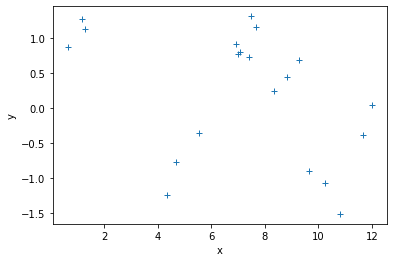

In [3]:
import matplotlib.pyplot as plt
plt.plot(x,y,"+",color="C0")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("hmc1.pdf")

In [4]:
import aesara.tensor as at
from aesara.graph import Apply, Op
import jax.numpy as jnp
import jax
from jax import config
from jax import vmap

#float64nise
config.update("jax_enable_x64", True)
x = np.array(x,dtype=np.float64)
y = np.array(y,dtype=np.float64)
phase = np.float64(phase)

def sinmodel(x, phase):
    return (jnp.sin(x + phase))

grad_sinmodel = jax.jit(jax.vmap(jax.grad(sinmodel, argnums=(0, 1)),in_axes=(0,None)))


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
sinmodel(x,phase)

DeviceArray([ 0.90333137,  0.9965908 ,  0.98016681, -0.99215406,
             -0.89100715, -0.23036223,  0.91154038,  0.92939441,
              0.95700625,  0.99861417,  0.98985979,  0.95524485,
              0.56165448,  0.08157524, -0.32639316, -0.64846527,
             -0.97161353, -0.95605865, -0.38817033, -0.05720499],            dtype=float64)

In [6]:
grad_sinmodel(x,phase)

(DeviceArray([ 0.42894339, -0.08250324, -0.19817423,  0.12502128,
               0.45398928,  0.97310495,  0.41121058,  0.36908812,
               0.2900673 , -0.05262835, -0.14204785, -0.29581628,
              -0.82737189, -0.99666719, -0.9452341 , -0.76124424,
              -0.23657378,  0.29317546,  0.92158765,  0.99836245],            dtype=float64),
 DeviceArray([ 0.42894339, -0.08250324, -0.19817423,  0.12502128,
               0.45398928,  0.97310495,  0.41121058,  0.36908812,
               0.2900673 , -0.05262835, -0.14204785, -0.29581628,
              -0.82737189, -0.99666719, -0.9452341 , -0.76124424,
              -0.23657378,  0.29317546,  0.92158765,  0.99836245],            dtype=float64))

In [26]:

class HMCGradOp(Op):
    def make_node(self, x, phase):
        inputs = [at.as_tensor_variable(x), at.as_tensor_variable(phase)]
        #outputs = [inp.type() for inp in inputs]
        outputs = [at.dvector(),at.dvector()] #the data structure as checked the previous cell
        #print("=>",outputs)
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        (grad_x, grad_phase) = grad_sinmodel(*inputs)
        outputs[0][0] = np.asarray(grad_x, dtype=node.outputs[0].dtype)
        outputs[1][0] = np.asarray(grad_phase, dtype=node.outputs[1].dtype)
        
hmc_grad_op = HMCGradOp()

#check
hmc_grad_op(x,phase)[1].eval()


array([ 0.42894339, -0.08250324, -0.19817423,  0.12502128,  0.45398928,
        0.97310495,  0.41121058,  0.36908812,  0.2900673 , -0.05262835,
       -0.14204785, -0.29581628, -0.82737189, -0.99666719, -0.9452341 ,
       -0.76124424, -0.23657378,  0.29317546,  0.92158765,  0.99836245])

In [27]:

class HMCOp(Op):
    def make_node(self, x, phase):
        inputs = [at.as_tensor_variable(x), at.as_tensor_variable(phase)]
        #outputs = [at.dscalar()]
        outputs = [at.dvector()]#YES, in our case, outputs is float64 vector 
                                #as shown by the output of sinmodel(x,phase).
        #https://aesara.readthedocs.io/en/latest/library/tensor/basic.html#all-fully-typed-constructors
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        result = sinmodel(*inputs)
        outputs[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)

    def grad(self, inputs, output_gradients):
        #(grad_x, grad_phase) = grad_sinmodel(*inputs)
        (grad_x, grad_phase) = hmc_grad_op(*inputs)
        output_gradient = output_gradients[0]
        return [output_gradient * grad_x, output_gradient * grad_phase]
    

#check
hmc_op = HMCOp()
hmc_op(x,phase).eval()



array([ 0.90333137,  0.9965908 ,  0.98016681, -0.99215406, -0.89100715,
       -0.23036223,  0.91154038,  0.92939441,  0.95700625,  0.99861417,
        0.98985979,  0.95524485,  0.56165448,  0.08157524, -0.32639316,
       -0.64846527, -0.97161353, -0.95605865, -0.38817033, -0.05720499])

In [28]:
import jax.numpy as jnp
import pymc

def build_model(x,y):
    with pymc.Model() as pmmodel:
        phase = pymc.Uniform('phase', lower = -1.0*jnp.pi, upper = 1.0*jnp.pi)
        sigma = pymc.Exponential('sigma', lam = 1.)
        mu=hmc_op(x,phase).eval()# jnp.sin(x+phase)
        d=pymc.Normal('y', mu = mu, sigma = sigma, observed=y)
    return pmmodel


In [32]:
model_pymc = build_model(x,y)
with model_pymc:
    #idata = pymc.sample(return_inferencedata=True)
    idata = pymc.sample(return_inferencedata=True)

array([[<AxesSubplot:title={'center':'phase'}>,
        <AxesSubplot:title={'center':'phase'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

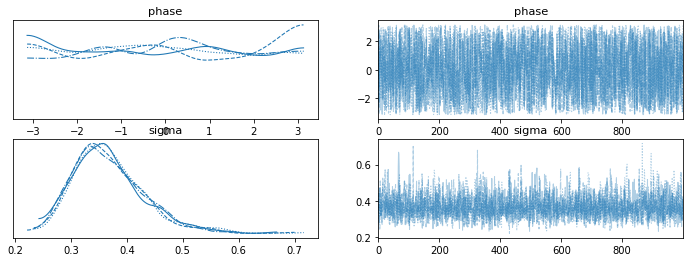

In [33]:
import arviz 
arviz.plot_trace(idata)

In [37]:
pymc.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
phase,0.003,1.824,-3.140,2.796,0.033,0.029,3010.0,2492.0,1.0
sigma,0.367,0.063,0.262,0.487,0.001,0.001,3141.0,2370.0,1.0


In [22]:
import jax.numpy as jnp
import pymc
import aesara.tensor as at
from aesara.graph import Apply, Op
    
        
def build_model(x,y):
    with pymc.Model() as pmmodel:
        phase = pymc.Uniform('phase', lower = -1.0*jnp.pi, upper = 1.0*jnp.pi)
        sigma = pymc.Exponential('sigma', lam = 1.)
        xa=at.as_tensor_variable(x)
        mu = at.as_tensor_variable(jnp.sin(jnp.ones(20)))
        d=pymc.Normal('y', mu = mu, sigma = sigma, observed=y)
    return pmmodel


In [23]:
model_pymc = build_model(x,y)
with model_pymc:
    idata = pymc.sample(return_inferencedata=True)

NotImplementedError: Cannot convert DeviceArray([0.841471, 0.841471, 0.841471, 0.841471, 0.841471, 0.841471,
             0.841471, 0.841471, 0.841471, 0.841471, 0.841471, 0.841471,
             0.841471, 0.841471, 0.841471, 0.841471, 0.841471, 0.841471,
             0.841471, 0.841471], dtype=float32) to a tensor variable.

In [33]:
from jax import random
from numpyro.infer import MCMC, NUTS

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000
# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(rng_key_, x=x, y=y)
mcmc.print_summary()

sample: 100%|████████████████████████████| 3000/3000 [00:05<00:00, 523.73it/s, 3 steps of size 8.17e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     phase      0.35      0.12      0.34      0.15      0.52   1178.68      1.00
     sigma      0.34      0.06      0.33      0.24      0.42   1307.40      1.00

Number of divergences: 0


In [34]:
samples = mcmc.get_samples()
samples["phase"]

DeviceArray([0.35946417, 0.35461283, 0.42814398, ..., 0.17406821,
             0.20636868, 0.27666712], dtype=float32)

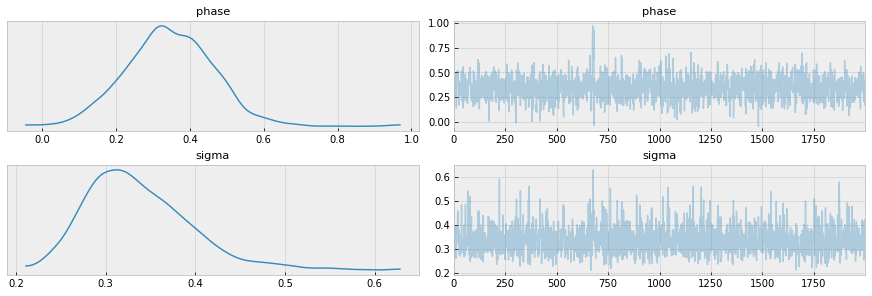

In [35]:
import arviz
arviz.plot_trace(mcmc, var_names=["phase","sigma"])
plt.savefig("hmc2.pdf")

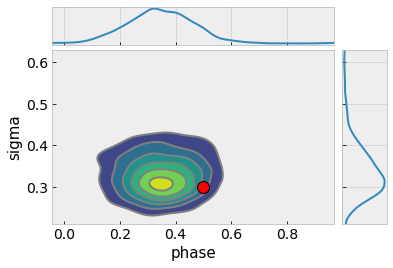

In [36]:
refs={};refs["sigma"]=sigin;refs["phase"]=phase
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',
    divergences=False,marginals=True,reference_values=refs,
    reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.savefig("hmc3.pdf", bbox_inches="tight", pad_inches=0.0)

In [37]:
posterior_phase = mcmc.get_samples()['phase']
posterior_sigma = mcmc.get_samples()['sigma']

In [38]:
from numpyro.infer import Predictive
pred = Predictive(model,{'phase':posterior_phase,'sigma':posterior_sigma},return_sites=["y"])
x_ = jnp.linspace(0,4*jnp.pi,1000)
predictions = pred(rng_key_,x=x_,y=None)

In [39]:
from numpyro.diagnostics import hpdi
mean_muy = jnp.mean(predictions["y"], axis=0)
hpdi_muy = hpdi(predictions["y"], 0.9)

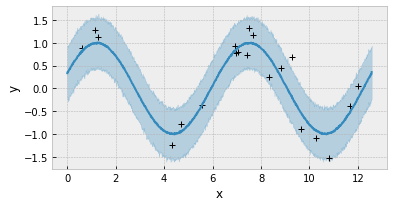

In [40]:
import seaborn as sns
plt.style.use('bmh')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(x,y,"+",color="black")
ax.plot(x_,mean_muy,color="C0")
ax.fill_between(x_, hpdi_muy[0], hpdi_muy[1], alpha=0.3, interpolate=True,color="C0")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("hmc4.pdf")